<a href="https://colab.research.google.com/github/violetcfelt/oceanfronts/blob/main/Training_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from google.colab import drive
import glob
import numpy as np
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from models import HED,CEDN
from keras.callbacks import ModelCheckpoint

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def custom_loss(logits, label):
    """
    Implements Equation [2] in https://arxiv.org/pdf/1504.06375.pdf
    """
    y = tf.cast(label, tf.float32)
    count_neg = tf.reduce_sum(1. - y)
    count_pos = tf.reduce_sum(y)
    beta = count_neg / (count_neg + count_pos)
    pos_weight = beta / (1 - beta)
    cost = tf.nn.weighted_cross_entropy_with_logits(logits=logits, labels=y, pos_weight=pos_weight)
    cost = tf.reduce_mean(cost * (1 - beta))
    return cost

In [8]:
model = CEDN()
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.compile(loss=custom_loss) #need the custom loss because of our weird output
# loss=tf.nn.sigmoid_cross_entropy_with_logits for CEDN

In [ ]:
scene_list = set()
for file in glob.glob("/content/drive/My Drive/pacific_train/*.npy"):
  substr = file.split('/')[-1].rsplit('_', 1)[0]
  if "output" not in substr:
    scene_list.add(substr)

print(scene_list)
print(len(scene_list))

{'LC08_042037_20191012', 'LC08_040038_20171024', 'LC08_039040_20210113', 'LC08_001084_20180908', 'LC08_044035_20200302', 'LC08_042037_20171006', 'LC08_042037_20191231', 'LC08_043036_20171130', 'LC08_047031_20191031', 'LC08_001084_20180127', 'LC08_036043_20190324', 'LC08_038041_20200104', 'LC08_040038_20201219', 'LC08_042037_20201115', 'LC08_001084_20200406', 'LC08_106037_20170430', 'LC08_040038_20201203', 'LC08_112040_20170219', 'LC08_040038_20181112', 'LC08_042037_20181228', 'LC08_042037_20201014', 'LC08_042037_20201201', 'LC08_046033_20171205', 'LC08_043036_20171013', 'LC08_045034_20210920', 'LC08_036043_20190119', 'LC08_001084_20180417', 'LC08_043036_20211125', 'LC08_044035_20180209', 'LC08_046033_20201026', 'LC08_040038_20210221', 'LC08_047031_20181012', 'LC08_001084_20191130', 'LC08_038043_20200104', 'LC08_044035_20181108', 'LC08_038041_20210327', 'LC08_046033_20180207', 'LC08_001084_20210220', 'LC08_044035_20190924', 'LC08_001084_20181026', 'LC08_044035_20181007', 'LC08_039040_20

In [ ]:
scene_list = list(scene_list)
X_train = np.empty((len(scene_list),224,224,3),dtype=np.float32)
Y_train = np.empty((len(scene_list),224,224,2),dtype=np.float32)
for scene_num in range(len(scene_list)):
  X_train[scene_num] = np.load('/content/drive/My Drive/pacific_train/' + scene_list[scene_num] + '_input.npy')[:,:,1:4]
  Y_train[scene_num] = np.load('/content/drive/My Drive/pacific_train/' + scene_list[scene_num] + '_output_binary.npy')

In [ ]:
print(X_train[0][5][0][0])

65.0


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

X_train = preprocess_input(X_train)

In [ ]:
print(X_train[0][5][0][0])

-55.939003


In [ ]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/best_model.hdf5", monitor='loss', verbose=1, save_best_only=True)
history = model.fit(X_train, Y_train, epochs=10, callbacks=[checkpoint])

Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 0.3466 
Epoch 1: loss improved from inf to 0.34663, saving model to /content/drive/My Drive/best_model.hdf5
2/2 [==============================] - 53s 16s/step - loss: 0.3466
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 0.3437 
Epoch 2: loss improved from 0.34663 to 0.34374, saving model to /content/drive/My Drive/best_model.hdf5
2/2 [==============================] - 53s 18s/step - loss: 0.3437
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 0.3437 
Epoch 3: loss improved from 0.34374 to 0.34374, saving model to /content/drive/My Drive/best_model.hdf5
2/2 [==============================] - 52s 17s/step - loss: 0.3437
Epoch 4/10
2/2 [==============================] - ETA: 0s - loss: 0.3437 
Epoch 4: loss improved from 0.34374 to 0.34374, saving model to /content/drive/My Drive/best_model.hdf5
2/2 [==============================] - 54s 17s/step - loss: 0.3437
Epoch 5/10
2/2 [========

In [ ]:
print(history.params)

{'verbose': 1, 'epochs': 25, 'steps': 2}


In [ ]:
print(history.history.keys())

dict_keys(['loss'])


In [ ]:
print(history.history['loss'])

[0.3096132278442383, 0.1656474620103836, 0.07818718254566193, 0.00244093406945467, 0.04042873531579971, 0.0015509966760873795, 0.0019418841693550348, 0.025605984032154083, 0.002032968681305647, 0.0010171903995797038, 0.0010769999353215098, 0.0007308431668207049, 4.029367119073868e-05, 2.4122680770233274e-05, 2.0411540390341543e-05, 1.82090461748885e-05, 1.6470839909743518e-05, 1.4938166714273393e-05, 1.3560455954575446e-05, 1.2127452464483213e-05, 9.931731256074272e-06, 4.882707344222581e-06, 2.4785963432805147e-06, 1.7243453385162866e-06, 1.3439500889944611e-06, 1.07341008970252e-06, 9.10563528577768e-07, 7.663498422516568e-07, 6.585956953131245e-07, 5.682373398485652e-07, 5.169077326172555e-07, 4.813848022422462e-07, 4.336783945291245e-07, 3.8380755995603977e-07, 3.565952511053183e-07, 3.2618359568914457e-07, 3.1271110856323503e-07, 2.594748877982056e-07, 2.4830865186231676e-07, 2.2302208435576176e-07, 2.139738910500455e-07, 1.7984517342028994e-07, 1.7195367263411754e-07, 1.646997418

Text(0.5, 1.0, 'Loss During Training')

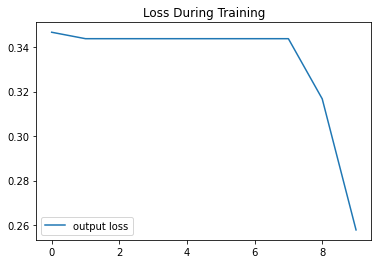

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label = 'output loss')
# plt.plot(history.history['conv2d_transpose_5_loss'], label = 'side loss 1')
# plt.plot(history.history['conv2d_transpose_6_loss'], label = 'side loss 2')
# plt.plot(history.history['conv2d_transpose_7_loss'], label = 'side loss 3')
# plt.plot(history.history['conv2d_transpose_8_loss'], label = 'side loss 4')
# plt.plot(history.history['conv2d_transpose_9_loss'], label = 'side loss 5')
plt.legend()
plt.title('Loss During Training')

Text(0.5, 1.0, 'Accuracy During Training')

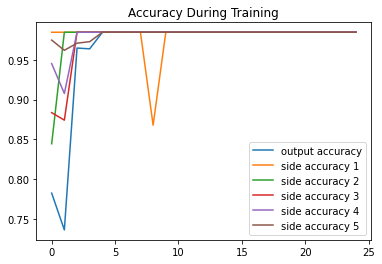

In [ ]:
plt.plot(history.history['conv2d_37_binary_accuracy'], label = 'output accuracy')
plt.plot(history.history['conv2d_transpose_5_binary_accuracy'], label = 'side accuracy 1')
plt.plot(history.history['conv2d_transpose_6_binary_accuracy'], label = 'side accuracy 2')
plt.plot(history.history['conv2d_transpose_7_binary_accuracy'], label = 'side accuracy 3')
plt.plot(history.history['conv2d_transpose_8_binary_accuracy'], label = 'side accuracy 4')
plt.plot(history.history['conv2d_transpose_9_binary_accuracy'], label = 'side accuracy 5')
plt.legend()
plt.title('Accuracy During Training')